# 3.1 Imports 

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

# 3.2 Load Data

In [2]:
orders17 = pd.read_csv(r'C:\Users\JIYOON JUNG\Desktop\Springboard\Unit 15 Data Wrangling\Capstone2\Brazilian E-Commerce Public Dataset by Olist\order17')

In [3]:
orders17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46836 entries, 0 to 46835
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       46836 non-null  object 
 1   customer_id                    46836 non-null  object 
 2   order_status                   46836 non-null  object 
 3   order_purchase_timestamp       46836 non-null  object 
 4   order_approved_at              46764 non-null  object 
 5   order_delivered_carrier_date   45681 non-null  object 
 6   order_delivered_customer_date  45140 non-null  object 
 7   order_estimated_delivery_date  46836 non-null  object 
 8   product_id                     46314 non-null  object 
 9   seller_id                      46314 non-null  object 
 10  shipping_limit_date            46314 non-null  object 
 11  price                          46314 non-null  float64
 12  freight_value                  46314 non-null 

In [4]:
orders17.shape

(46836, 32)

In [25]:
orders17[orders17['order_size'] == 10].head().T

,33587,36313,43437,43438,46634
order_id,f80549a97eb203e1566e026ab66f045b,9f5054bd9a3c71702aa0917a7da29193,f60ce04ff8060152c83c7c97e246d6a8,f60ce04ff8060152c83c7c97e246d6a8,9aec4e1ae90b23c7bf2d2b3bfafbd943
customer_id,4a60b2ce1ee8c7b828e4bbcca5b86b41,cb87122c4871e202777cf243fbea2d12,78fc46047c4a639e81ff65f0396e02fe,78fc46047c4a639e81ff65f0396e02fe,e7d6802668de6e74d0d6c56565bf2a24
order_status,delivered,delivered,delivered,delivered,delivered
order_purchase_timestamp,2017-09-12 10:31:42,2017-10-05 09:13:21,2017-11-28 22:24:18,2017-11-28 22:24:18,2017-10-02 15:49:23
order_approved_at,2017-09-13 03:15:47,2017-10-06 02:14:23,2017-11-28 22:31:34,2017-11-28 22:31:34,2017-10-02 16:05:19
order_delivered_carrier_date,2017-09-19 13:32:36,2017-10-09 19:22:42,2017-11-29 19:48:33,2017-11-29 19:48:33,2017-10-09 21:33:34
order_delivered_customer_date,2017-09-26 15:25:15,2017-10-16 21:07:36,2017-12-04 22:22:20,2017-12-04 22:22:20,2017-10-11 17:11:54
order_estimated_delivery_date,2017-09-28,2017-11-09,2017-12-18,2017-12-18,2017-10-24
product_id,d5991653e037ccb7af6ed7d94246b249,54d7ad85b648d3cb2b7069ed446d7f35,58efb9b638561ce132216a9a612513e2,872db866d615db59612ac933f43d6b22,0db4869ac8a908414823d44d742f5ba3
seller_id,25c5c91f63607446a97b143d2d535d31,25c5c91f63607446a97b143d2d535d31,701938c450705b8ae65fc923b70f35c7,701938c450705b8ae65fc923b70f35c7,7c67e1448b00f6e969d365cea6b010ab


In [24]:
orders17[orders17['order_id'] == '82bce245b1c9148f8d19a55b9ff70644']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,...,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,order_size,Year,Month,product_qty
30,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-04-24 09:34:13,2017-05-10 09:17:55,2017-05-12,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,...,22.0,28.0,4445.0,sao paulo,SP,housewares,5,2017,4,5.0


# 3.3 Pre-processing

###### Drop the rows with missing values.

In [5]:
missing = pd.concat([orders17.isnull().sum(), 100 * orders17.isnull().mean()], axis=1)
missing.columns=['count', '%']
print(missing.sort_values('%',ascending=False))

                               count         %
order_delivered_customer_date   1696  3.621146
product_category_name_english   1350  2.882398
product_photos_qty              1350  2.882398
product_description_length      1350  2.882398
product_name_length             1350  2.882398
order_delivered_carrier_date    1155  2.466052
product_height_cm                538  1.148689
product_length_cm                538  1.148689
product_weight_g                 538  1.148689
product_width_cm                 538  1.148689
seller_zip_code_prefix           522  1.114527
seller_city                      522  1.114527
seller_state                     522  1.114527
product_qty                      522  1.114527
freight_value                    522  1.114527
shipping_limit_date              522  1.114527
seller_id                        522  1.114527
product_id                       522  1.114527
price                            522  1.114527
order_approved_at                 72  0.153728
order_size   

In [8]:
orders17.dropna(inplace = True)

In [9]:
orders17.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44334 entries, 0 to 46835
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       44334 non-null  object 
 1   customer_id                    44334 non-null  object 
 2   order_status                   44334 non-null  object 
 3   order_purchase_timestamp       44334 non-null  object 
 4   order_approved_at              44334 non-null  object 
 5   order_delivered_carrier_date   44334 non-null  object 
 6   order_delivered_customer_date  44334 non-null  object 
 7   order_estimated_delivery_date  44334 non-null  object 
 8   product_id                     44334 non-null  object 
 9   seller_id                      44334 non-null  object 
 10  shipping_limit_date            44334 non-null  object 
 11  price                          44334 non-null  float64
 12  freight_value                  44334 non-null 

In [13]:
orders17.describe().T

,count,mean,std,min,25%,50%,75%,max
price,44334.0,123.860106,189.425454,1.2,40.00,76.00,139.00,6735.0
freight_value,44334.0,19.481204,14.367541,0.0,13.43,16.11,20.14,314.4
customer_zip_code_prefix,44334.0,36360.245816,29842.710605,1004.0,12285.25,26277.00,60713.75,99980.0
product_name_length,44334.0,48.682163,10.138388,5.0,42.00,52.00,57.00,72.0
product_description_length,44334.0,757.776312,648.090385,4.0,337.00,575.00,955.00,3992.0
product_photos_qty,44334.0,2.253192,1.730291,1.0,1.00,2.00,3.00,18.0
product_weight_g,44334.0,2194.107795,3931.728269,50.0,300.00,764.00,1850.00,40425.0
product_length_cm,44334.0,31.017707,16.291688,7.0,19.00,26.00,40.00,105.0
product_height_cm,44334.0,16.852709,13.754744,2.0,8.00,13.00,21.00,105.0
product_width_cm,44334.0,23.810868,12.173166,6.0,15.00,20.00,30.00,118.0


#### Select columns for data analysis.

In [39]:
df = pd.DataFrame(orders17[['Year', 'Month', 'order_id', 'order_size','order_purchase_timestamp', 'product_category_name_english','product_id', 'product_qty','price' ]])
df

,Year,Month,order_id,order_size,order_purchase_timestamp,product_category_name_english,product_id,product_qty,price
0,2017,10,e481f51cbdc54678b7cc49136f2d6af7,1,2017-10-02 10:56:33,housewares,87285b34884572647811a353c7ac498a,1.0,29.99
1,2017,11,949d5b44dbf5de918fe9c16f97b45f8a,1,2017-11-18 19:28:06,pet_shop,d0b61bfb1de832b15ba9d266ca96e5b0,1.0,45.00
2,2017,7,a4591c265e18cb1dcee52889e2d8acc3,1,2017-07-09 21:57:05,auto,060cb19345d90064d1015407193c233d,1.0,147.90
4,2017,5,6514b8ad8028c9f2cc2374ded245783f,1,2017-05-16 13:10:30,auto,4520766ec412348b8d4caa5e8a18c464,1.0,59.99
5,2017,1,76c6e866289321a7c93b82b54852dc33,1,2017-01-23 18:29:09,furniture_decor,ac1789e492dcd698c5c10b97a671243a,1.0,19.90
...,...,...,...,...,...,...,...,...,...
46831,2017,10,9115830be804184b91f5c00f6f49f92d,2,2017-10-04 19:57:37,toys,49d2e2460386273b195e7e59b43587c3,1.0,26.90
46832,2017,1,aa04ef5214580b06b10e2a378300db44,1,2017-01-27 00:30:03,health_beauty,9fc063fd34fed29ccc57b7f8e8d03388,1.0,370.00
46833,2017,2,880675dff2150932f1601e1c07eadeeb,1,2017-02-23 09:05:12,furniture_decor,ea73128566d1b082e5101ce46f8107c7,1.0,139.90
46834,2017,3,9c5dedf39a927c1b2549525ed64a053c,1,2017-03-09 09:54:05,health_beauty,ac35486adb7b02598c182c2ff2e05254,1.0,72.00


In [40]:
total_sales = df.groupby(by='Month')["price"].sum()
total_qty = df.groupby(by='Month')["product_qty"].sum()
revenue_per_item = (df.groupby(by='Month')["price"].sum()/ df.groupby(by='Month')["product_qty"].sum()).round(2)
order_size = (df.groupby(by='Month')["product_qty"].sum()/df.groupby(by='Month')["order_id"].nunique()).round(2)

sales = pd.DataFrame(
    {'Total_Sales': total_sales,
     'Total_Qty': total_qty,
     'Revenue_per_Item': revenue_per_item,
     'Order_Size': order_size})
sales

,Total_Sales,Total_Qty,Revenue_per_Item,Order_Size
Month,,,,
1,99149.16,898.0,110.41,1.22
2,212400.16,1790.0,118.66,1.12
3,333704.94,2837.0,117.63,1.14
4,316517.26,2500.0,126.61,1.11
5,450738.81,3912.0,115.22,1.13
6,400488.91,3431.0,116.73,1.11
7,449260.05,4358.0,103.09,1.14
8,515095.49,4722.0,109.08,1.14
9,550193.89,4663.0,117.99,1.14


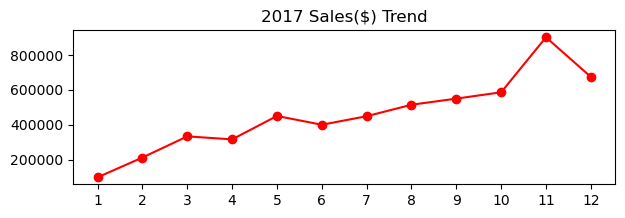

In [41]:
x_values = sales.index.to_list()
y_values = sales['Total_Sales'].values
fig, ax = plt.subplots(figsize=(7, 2))
ax.plot(x_values, y_values, marker='o', linestyle='-', color='r')
ax.set_xticks(range(1, 13))
ax.set(title="2017 Sales($) Trend")
plt.show()

In [42]:
orders17['order_purchase_timestamp'] = pd.to_datetime(orders17['order_purchase_timestamp'])
orders17['order_purchase_timestamp'] = orders17['order_purchase_timestamp'].dt.strftime('%Y-%m-%d')

In [45]:
total_sales_day = orders17.groupby(by = "order_purchase_timestamp")["price"].sum()
total_qty_day = orders17.groupby(by='order_purchase_timestamp')["order_size"].sum()
revenue_per_item_day = (orders17.groupby(by='order_purchase_timestamp')["price"].sum()/ orders17.groupby(by='order_purchase_timestamp')["order_size"].sum()).round(2)
order_size_day = (orders17.groupby(by='order_purchase_timestamp')["order_size"].sum()/orders17.groupby(by='order_purchase_timestamp')["order_id"].nunique()).round(2)

sales_day = pd.DataFrame(
    {'Total_Sales': total_sales_day,
     'Total_Qty': total_qty_day,
     'Revenue_per_Item': revenue_per_item_day,
     'Order_Size': order_size_day}).reset_index()
sales_day

,order_purchase_timestamp,Total_Sales,Total_Qty,Revenue_per_Item,Order_Size
0,2017-01-05,396.90,32,12.40,1.00
1,2017-01-06,916.38,4,229.10,1.00
2,2017-01-07,952.90,5,190.58,1.25
3,2017-01-08,449.78,4,112.44,1.00
4,2017-01-09,635.29,6,105.88,1.20
...,...,...,...,...,...
356,2017-12-27,14867.74,189,78.67,1.25
357,2017-12-28,13545.71,153,88.53,1.11
358,2017-12-29,14616.91,175,83.53,1.38
359,2017-12-30,11926.48,110,108.42,1.22


In [46]:
sales_day['order_purchase_timestamp'] = pd.to_datetime(sales_day['order_purchase_timestamp'])

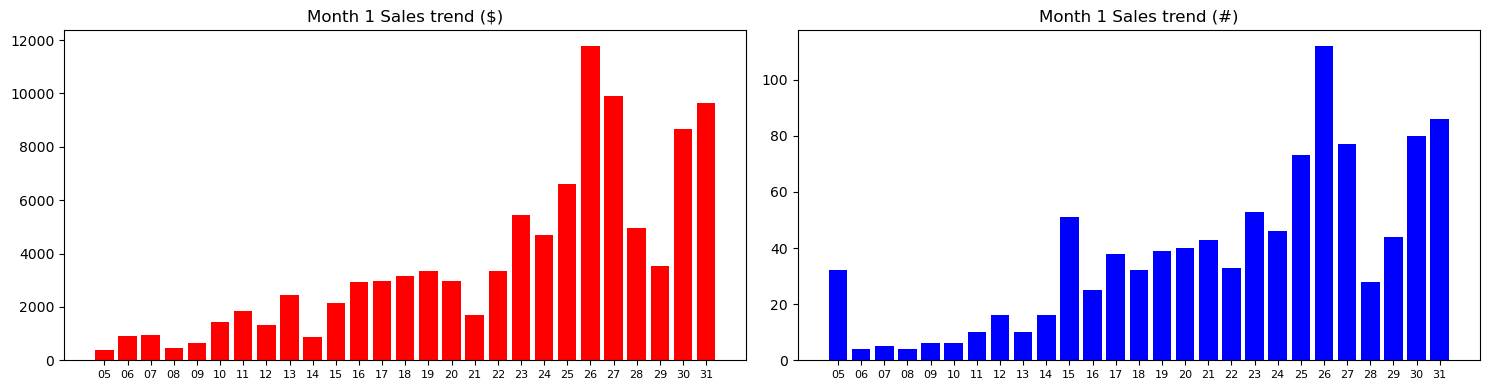

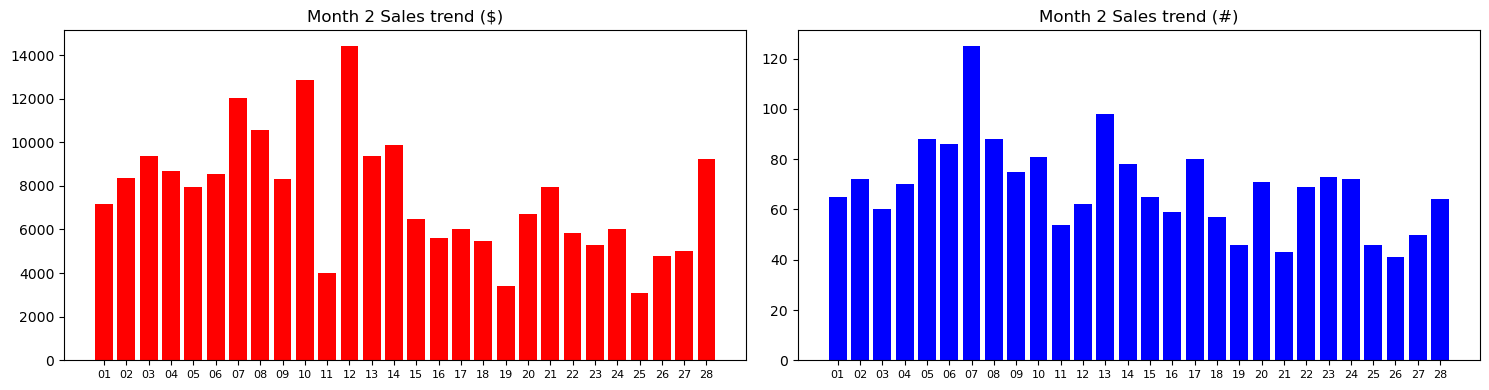

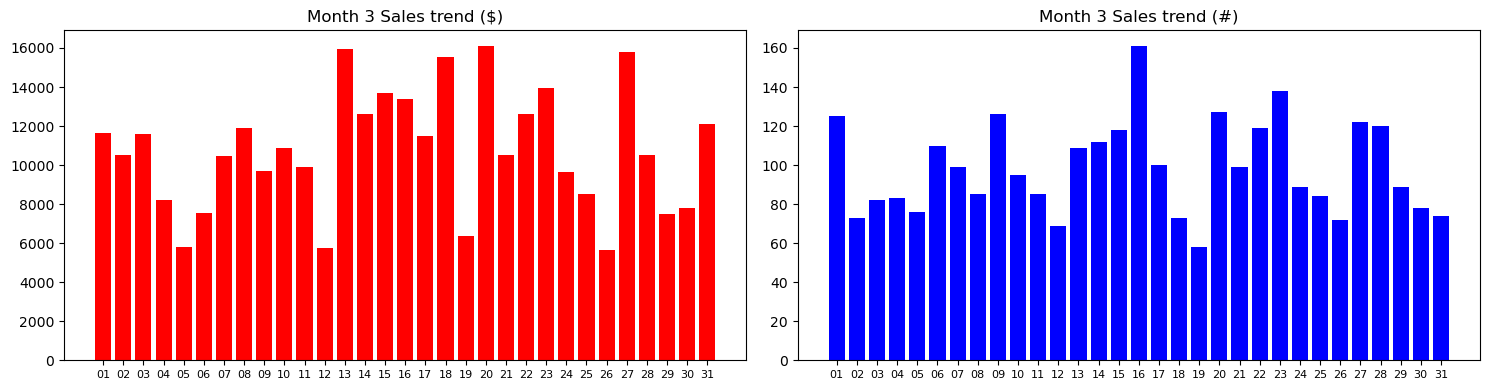

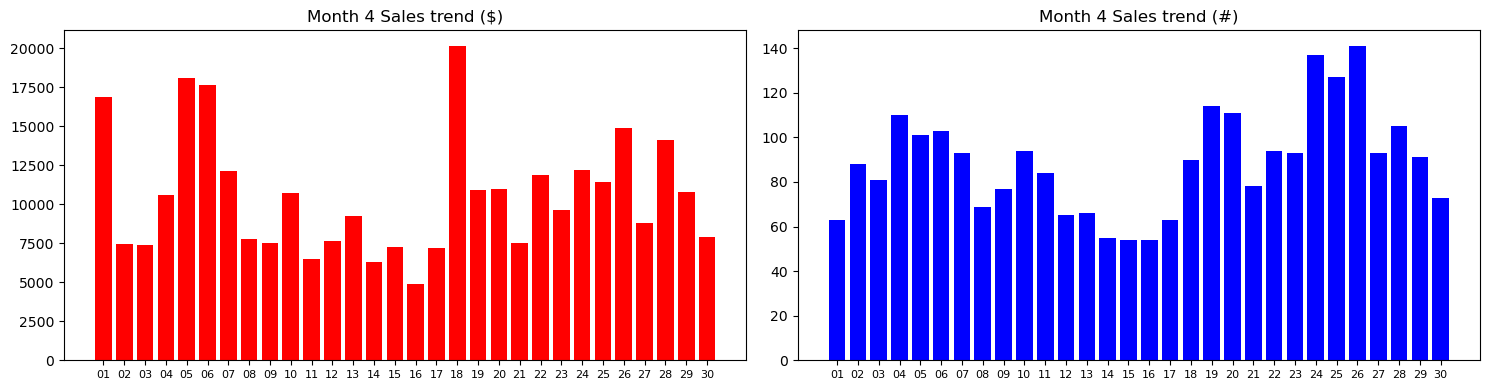

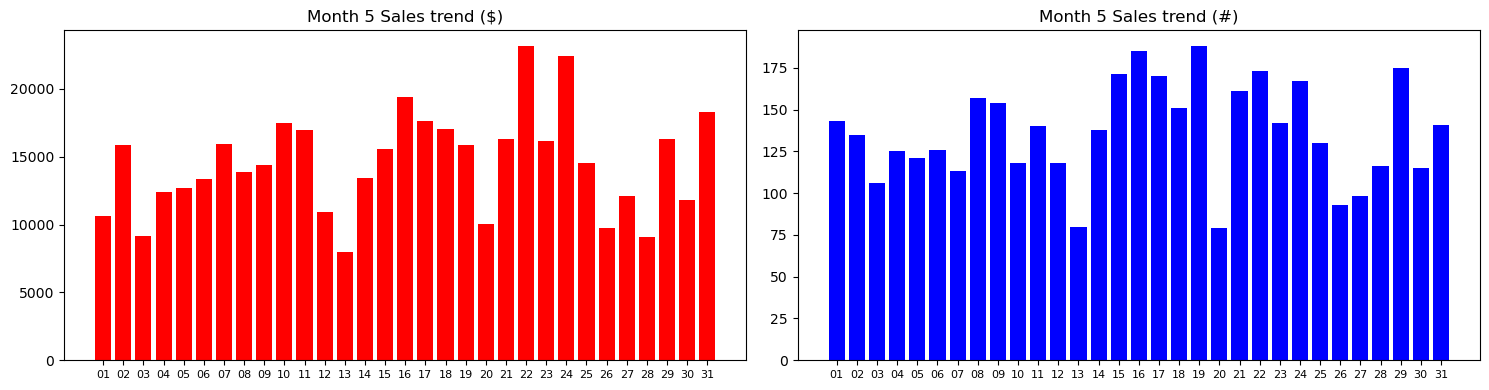

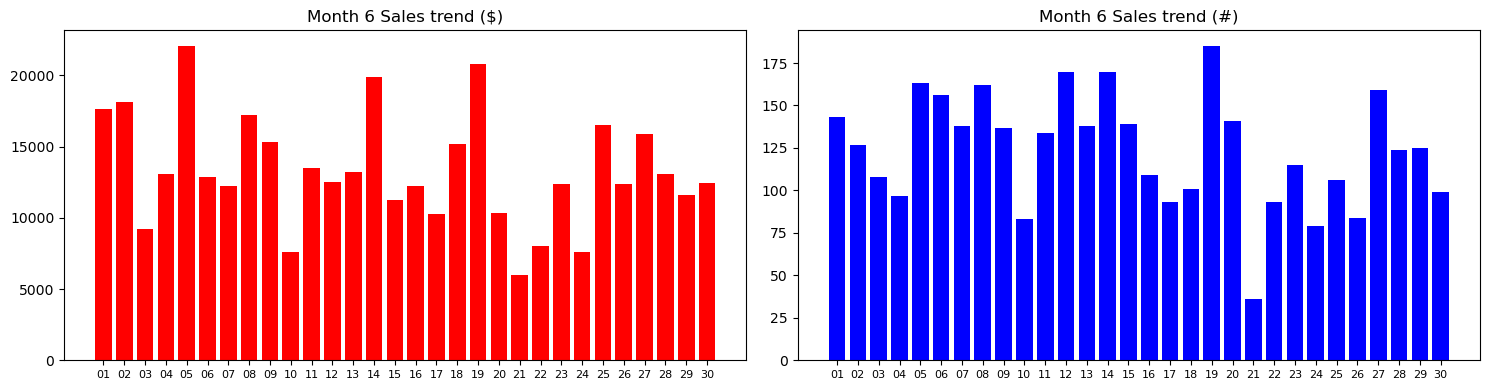

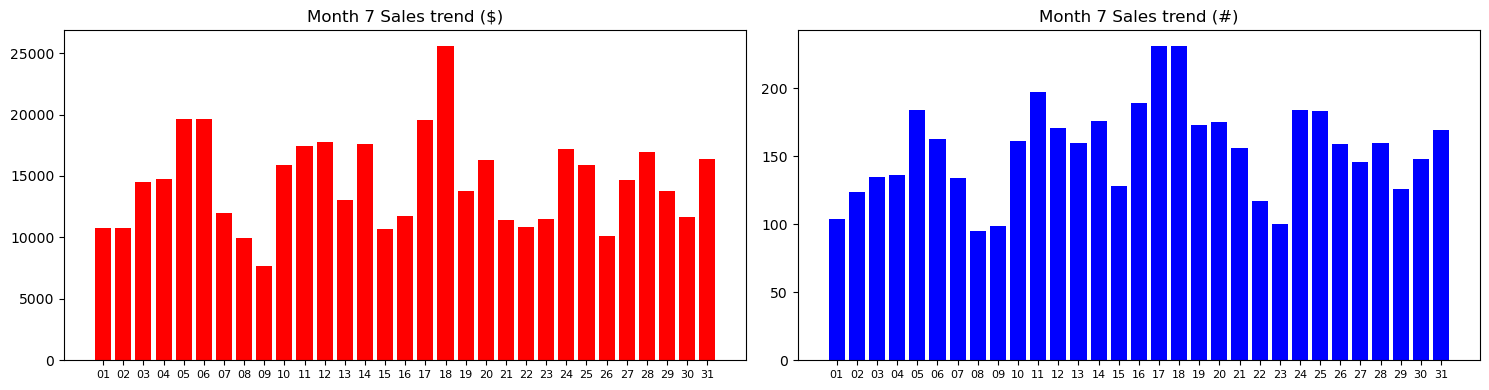

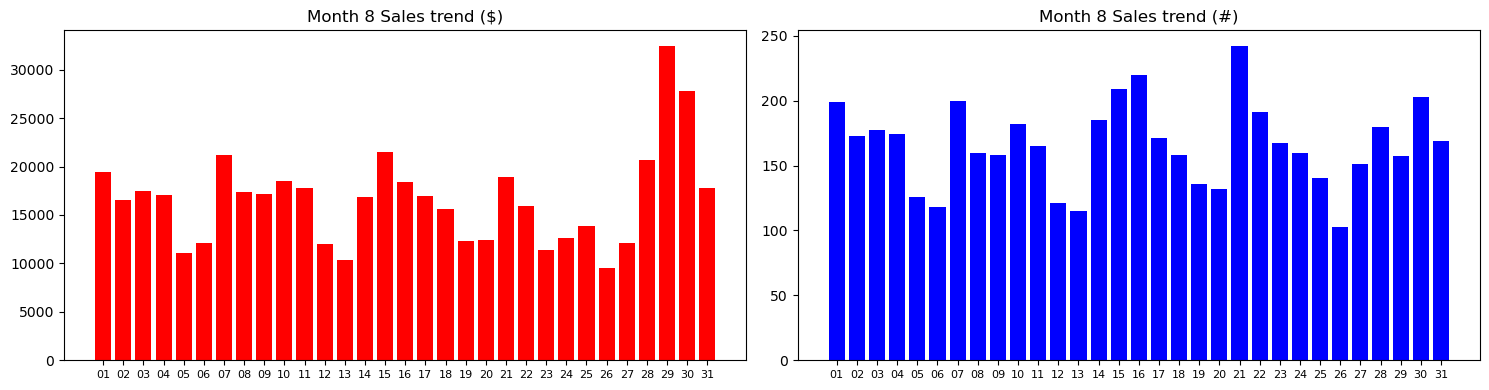

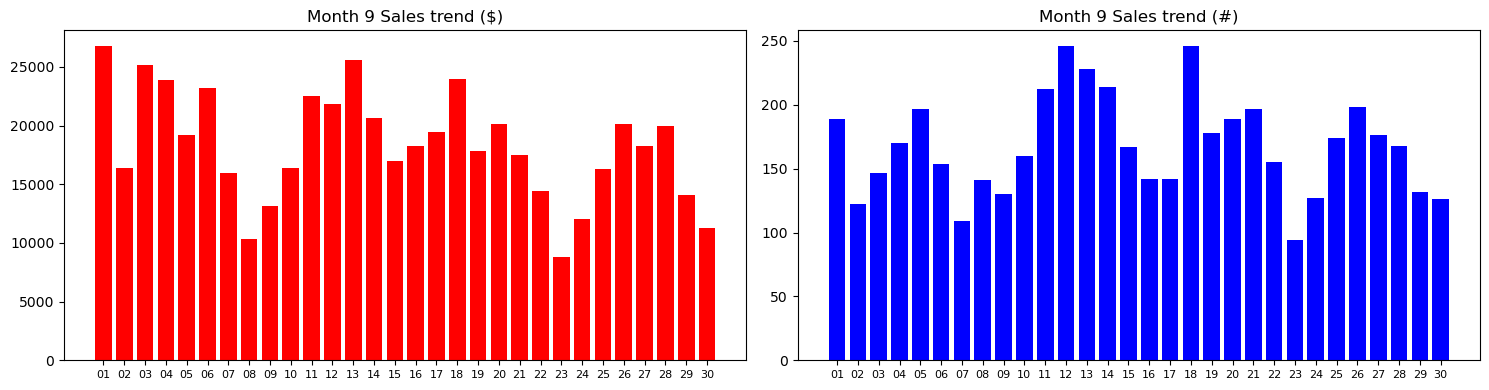

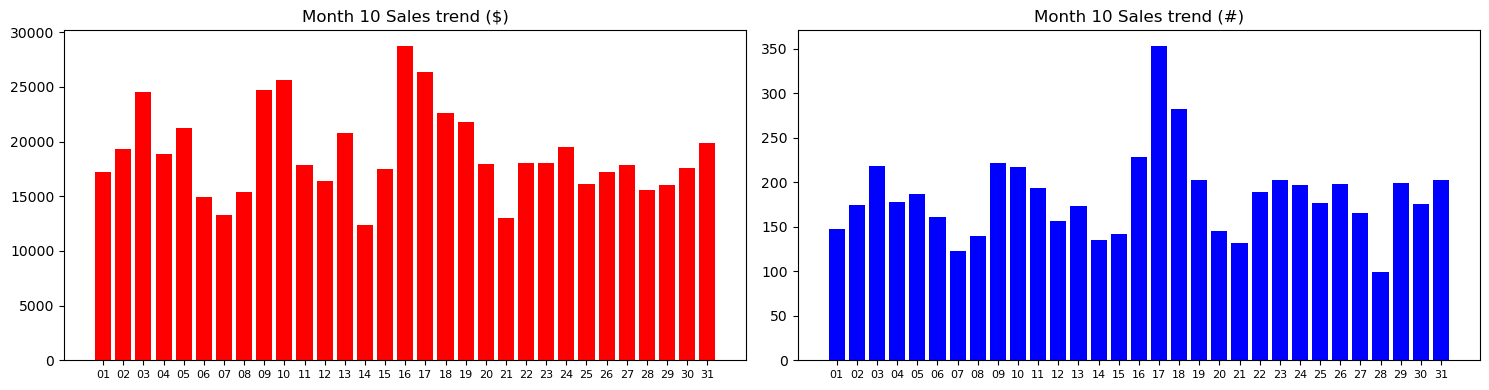

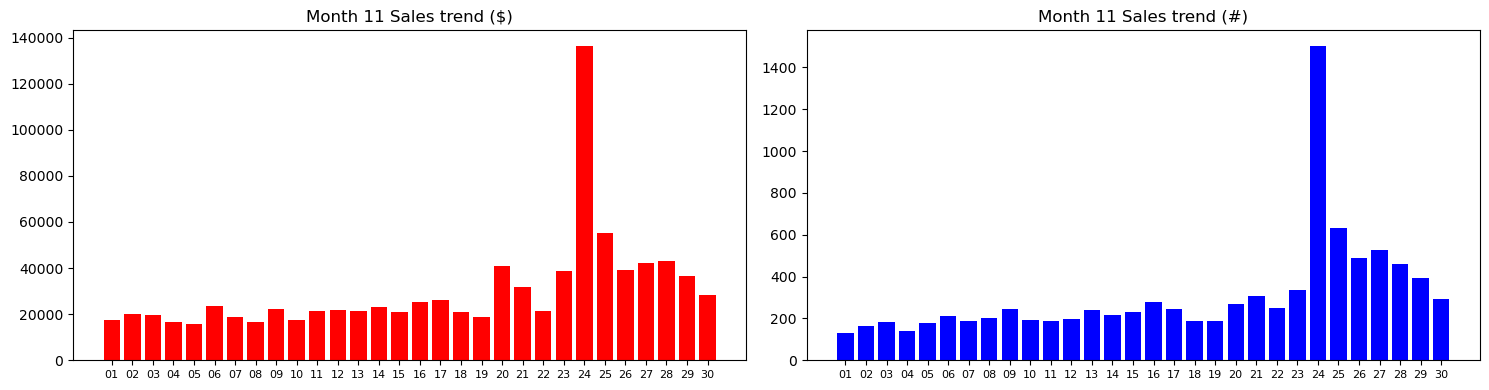

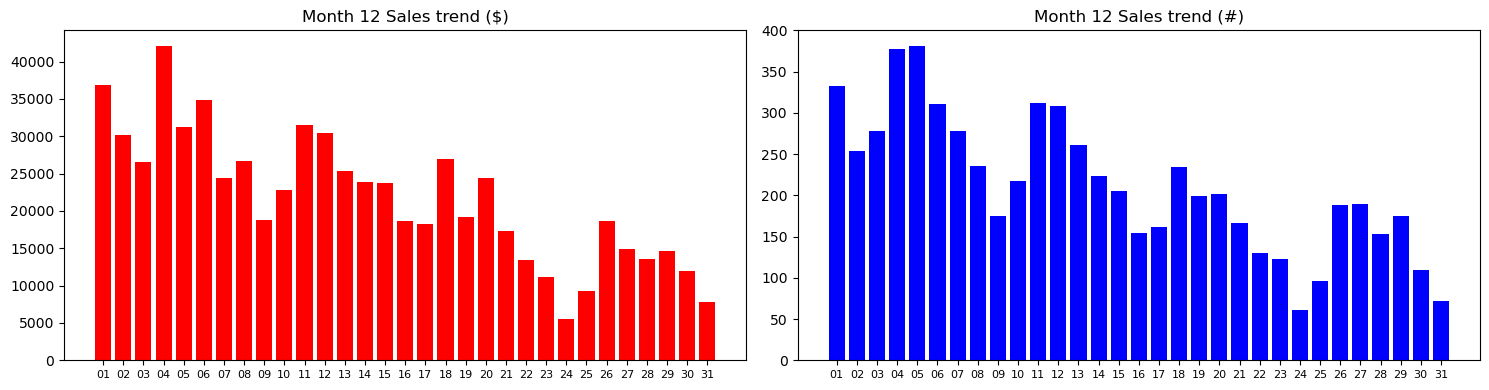

In [47]:
for i in range(1, 13):
    filtered_data = sales_day[sales_day['order_purchase_timestamp'].dt.month == i]
    date_strings = [date.strftime('%d') for date in filtered_data['order_purchase_timestamp']]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))  # Create subplots with 1 row and 2 columns
    
    # First subplot - Total Sales
    y_values_sales = filtered_data['Total_Sales'].values
    ax1.bar(date_strings, y_values_sales, color='r')
    ax1.set_xticks(range(len(date_strings)))
    ax1.set_xticklabels(date_strings, size=8)
    ax1.set(title=f"Month {i} Sales trend ($)")

    # Second subplot - Total Quantity
    y_values_qty = filtered_data['Total_Qty'].values
    ax2.bar(date_strings, y_values_qty, color='b')
    ax2.set_xticks(range(len(date_strings)))
    ax2.set_xticklabels(date_strings, size=8)
    ax2.set(title=f"Month {i} Sales trend (#)")
    
    plt.tight_layout()
    plt.show()

In [105]:
product = pd.DataFrame(orders17.groupby(by=['order_purchase_timestamp',"product_category_name_english"])['product_qty'].sum().round(3))
product = product.reset_index()
product = product.pivot(index = 'product_category_name_english', columns = 'order_purchase_timestamp', values = 'product_qty')
product['Total'] = product.sum(axis=1)
product = product.sort_values(by="Total", ascending=False).T
product = product.fillna(0)
product = product.reset_index()
product

product_category_name_english,order_purchase_timestamp,bed_bath_table,furniture_decor,sports_leisure,health_beauty,computers_accessories,housewares,toys,garden_tools,cool_stuff,...,party_supplies,la_cuisine,flowers,cine_photo,fashion_childrens_clothes,pc_gamer,small_appliances_home_oven_and_coffee,security_and_services,arts_and_craftmanship,diapers_and_hygiene
0,2017-01-05,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-01-06,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-01-07,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-01-08,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-01-09,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,2017-12-28,16.0,7.0,8.0,12.0,2.0,7.0,7.0,13.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
358,2017-12-29,18.0,9.0,6.0,9.0,7.0,5.0,5.0,14.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,2017-12-30,11.0,8.0,7.0,4.0,3.0,2.0,4.0,13.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,2017-12-31,3.0,6.0,1.0,7.0,3.0,1.0,4.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Train and Test dataset setup

In [107]:
train = pd.concat([sales_day, product.iloc[:362, :]], axis=1)
train = train.iloc[:-1, :]

train

,order_purchase_timestamp,Total_Sales,Total_Qty,Revenue_per_Item,Order_Size,order_purchase_timestamp,bed_bath_table,furniture_decor,sports_leisure,health_beauty,...,party_supplies,la_cuisine,flowers,cine_photo,fashion_childrens_clothes,pc_gamer,small_appliances_home_oven_and_coffee,security_and_services,arts_and_craftmanship,diapers_and_hygiene
0,2017-01-05,396.90,32.0,12.40,1.00,2017-01-05,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-01-06,916.38,4.0,229.10,1.00,2017-01-06,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-01-07,952.90,5.0,190.58,1.25,2017-01-07,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-01-08,449.78,4.0,112.44,1.00,2017-01-08,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-01-09,635.29,6.0,105.88,1.20,2017-01-09,0.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,2017-12-27,14867.74,189.0,78.67,1.25,2017-12-27,20.0,8.0,8.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
357,2017-12-28,13545.71,153.0,88.53,1.11,2017-12-28,16.0,7.0,8.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
358,2017-12-29,14616.91,175.0,83.53,1.38,2017-12-29,18.0,9.0,6.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,2017-12-30,11926.48,110.0,108.42,1.22,2017-12-30,11.0,8.0,7.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
def resumetable(df):
    print(f'shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['data type'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': 'features'})
    summary['Missing values'] = df.isnull().sum().values
    summary['Unique values'] = df.nunique().values
    
    return summary

resumetable(train)

shape: (361, 78)


,features,data type,Missing values,Unique values
0,order_purchase_timestamp,datetime64[ns],0,361
1,Total_Sales,float64,0,361
2,Total_Qty,float64,0,189
3,Revenue_per_Item,float64,0,354
4,Order_Size,float64,0,55
...,...,...,...,...
73,pc_gamer,float64,0,2
74,small_appliances_home_oven_and_coffee,float64,0,2
75,security_and_services,float64,0,2
76,arts_and_craftmanship,float64,0,2


In [110]:
train

,order_purchase_timestamp,Total_Sales,Total_Qty,Revenue_per_Item,Order_Size,order_purchase_timestamp,bed_bath_table,furniture_decor,sports_leisure,health_beauty,...,party_supplies,la_cuisine,flowers,cine_photo,fashion_childrens_clothes,pc_gamer,small_appliances_home_oven_and_coffee,security_and_services,arts_and_craftmanship,diapers_and_hygiene
0,2017-01-05,396.90,32.0,12.40,1.00,2017-01-05,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-01-06,916.38,4.0,229.10,1.00,2017-01-06,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-01-07,952.90,5.0,190.58,1.25,2017-01-07,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-01-08,449.78,4.0,112.44,1.00,2017-01-08,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-01-09,635.29,6.0,105.88,1.20,2017-01-09,0.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,2017-12-27,14867.74,189.0,78.67,1.25,2017-12-27,20.0,8.0,8.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
357,2017-12-28,13545.71,153.0,88.53,1.11,2017-12-28,16.0,7.0,8.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
358,2017-12-29,14616.91,175.0,83.53,1.38,2017-12-29,18.0,9.0,6.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,2017-12-30,11926.48,110.0,108.42,1.22,2017-12-30,11.0,8.0,7.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


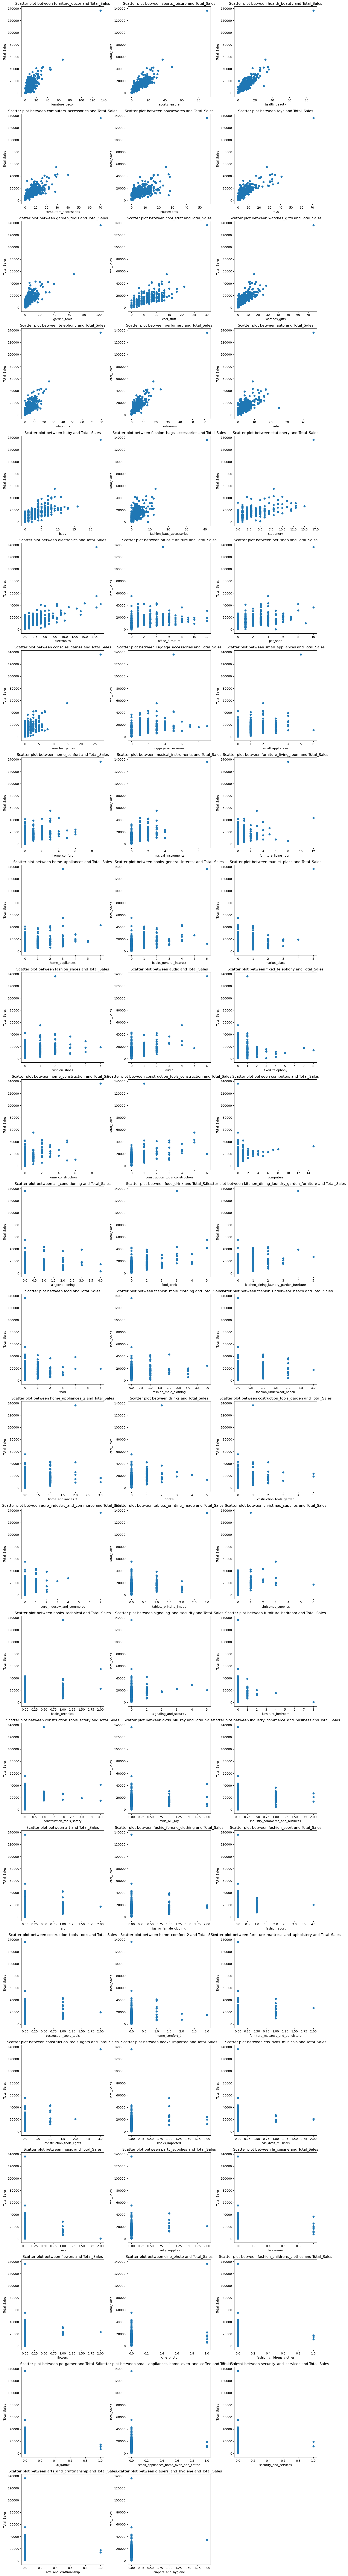

In [125]:
import matplotlib.pyplot as plt


columns_for_scatter = train.columns[7:]


num_plots = len(columns_for_scatter)
num_cols = 3  # You can adjust the number of columns as per your preference
num_rows = -(-num_plots // num_cols)  # Ceiling division to calculate the number of rows

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))


axes = axes.flatten()


for i, column in enumerate(columns_for_scatter):
    data = train[[column, 'Total_Sales']].dropna()
    
    # Plot on the corresponding subplot
    axes[i].scatter(data[column], data['Total_Sales'])
    axes[i].set_title(f'Scatter plot between {column} and Total_Sales')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Total_Sales')

for j in range(num_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

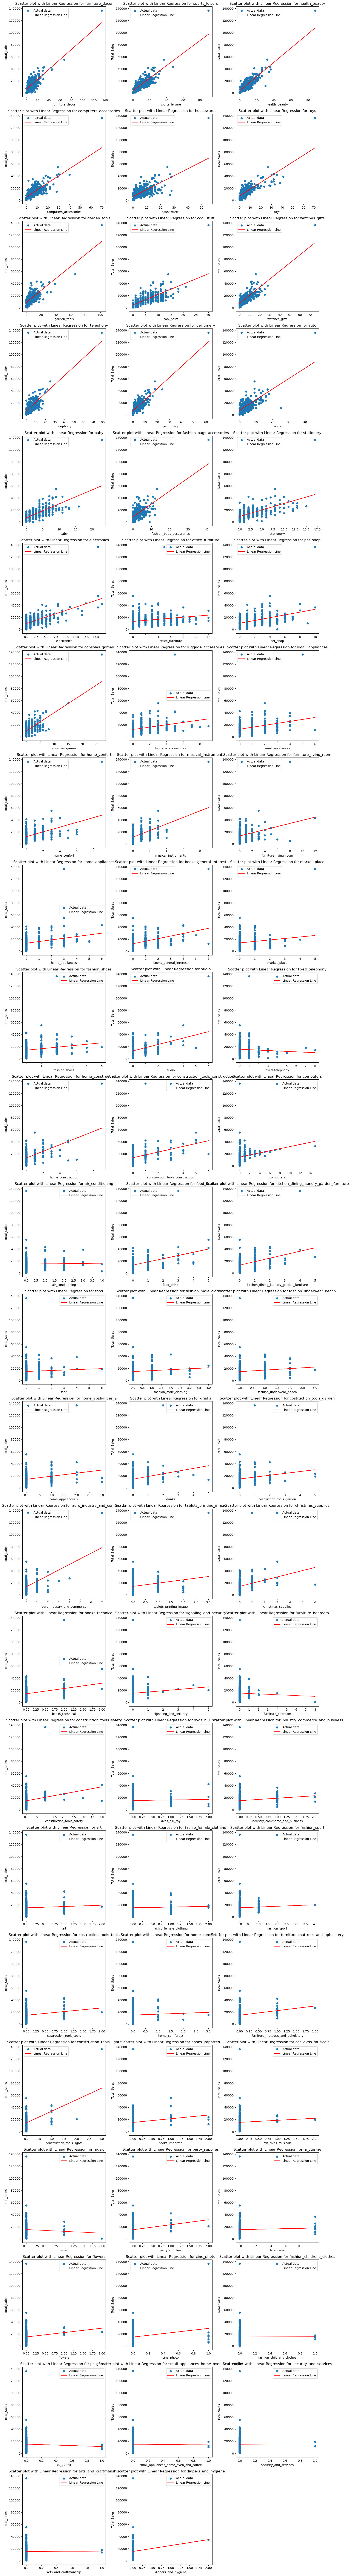

In [126]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

columns_for_scatter = train.columns[7:]

# Set up subplots
num_plots = len(columns_for_scatter)
num_cols = 3  # You can adjust the number of columns as per your preference
num_rows = -(-num_plots // num_cols)  # Ceiling division to calculate the number of rows

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

axes = axes.flatten()

model = LinearRegression()

# Loop through columns and plot scatter plots with linear regression lines
for i, column in enumerate(columns_for_scatter):
    # Drop missing values before plotting
    data = train[[column, 'Total_Sales']].dropna()
    
    # Fit Linear Regression model
    X = data[[column]]
    y = data['Total_Sales']
    model.fit(X, y)
    
    # Plot scatter plot
    axes[i].scatter(data[column], data['Total_Sales'], label='Actual data')
    
    # Plot linear regression line
    axes[i].plot(X, model.predict(X), color='red', label='Linear Regression Line')
    
    axes[i].set_title(f'Scatter plot with Linear Regression for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Total_Sales')
    axes[i].legend()

# Hide empty subplots
for j in range(num_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()